## Transversely isotropic viscosity

This notebook uses compressional boundary conditions to reproduce the results from Sharples et al, 2016 (I think).

Apply compressional stresses to a region with transversely isotropic material. If the orientation of the director is oriented parallel / perpendicular to the compressive principle stress direction then the 1st viscosity should be the only active parameter; if at 45 degrees then only the second viscosity will be active. 

This should be reflected in the stress state ... but note that the current machinery is not very helpful in obtaining stress except when there is a scalar viscosity.

In [1]:
import underworld as uw
from underworld import function as fn

import glucifer

uw.matplotlib_inline()

# import matplotlib.pyplot as pyplot
# import matplotlib.pylab as pylab
import numpy as np
import math
import os


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:

workdir = os.path.abspath(".")
outputPath = os.path.join(workdir,"TransIsoFault-v1/")

if uw.rank() == 0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    
uw.barrier()   


Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [3]:
minX  = -2.0;   minY = 0.0
maxX  =  2.0;   maxY = 1.0
minXv =  2.0
maxXv =  0.0

resX = 128
resY = 32

elementType="Q2/dPc1"  # This is enough for a test but not to use the code in anger

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, minY), 
                                 maxCoord    = ( maxX, maxY),
                                 periodic    = [False, False]  ) 



velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:]   = [0.,0.]
pressureField.data[:]   = 0.

# Define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

### Boundary conditions

Pure shear with moving  side walls — all boundaries are zero traction with outflow top and bottom
to accommodate changing volume

In [4]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

leftI  = mesh.specialSets["MinI_VertexSet"]
rightI = mesh.specialSets["MaxI_VertexSet"]
bothIs = leftI + rightI

baseWall   = mesh.specialSets["MinJ_VertexSet"]
topWall    = mesh.specialSets["MaxJ_VertexSet"]

allWalls = iWalls + jWalls

velocityBCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                indexSetsPerDof = (bothIs, leftI+baseWall) )

for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [minXv, 0.]

for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [maxXv, 0.]
    
for index in mesh.specialSets["MinJ_VertexSet"]:
    velocityField.data[index] = [0., 0.]
       
    

### Setup the material swarm and passive tracers

The material swarm is used for tracking deformation and history dependence of the rheology

Passive swarms can track all sorts of things but lack all the machinery for integration and re-population

In [5]:
swarm  = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=50 )
swarm.populate_using_layout( layout=swarmLayout )

# Population control may be useful

pop_control = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=50)

advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

In [6]:
# Tracking different materials etc

materialVariable       = swarm.add_variable( dataType="int", count=1 )

# Tracking the fault information


proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="float", count=1 )
directorVector   = swarm.add_variable( dataType="double", count=2)

directorVector.data[:,:] = 0.0
proximityVariable.data[:] = 0
signedDistanceVariable.data[:] = 0.0

### Material distribution in the domain.

(and identification of fault points)

In [7]:
# Initialise the 'materialVariable' data to represent different materials. 

materialA  = 0 # accommodation layer a.k.a. Sticky Air
materialV  = 1 # Rigid blocks

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.

yCoord = fn.coord()[1]

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.

conditions = [ (       yCoord > 0.65 ,                     materialA ),
               (       yCoord < 0.0  ,                     materialA ),
               (       True ,                              materialV ) ]

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.

materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

In [8]:
from unsupported.interfaces import markerLine2D

# Local copy of data structure representing a fault


faults = []

forientation = np.radians(22.5)
fthickness = 0.05

faultLine1 = (0.0, 0.0)
faultLine2 = (0.5 * np.tan(0.5*np.pi + forientation), 0.85)

faultLineXs = np.linspace(faultLine1[0], faultLine2[0], 100)
faultLineYs = 2.0 * (np.linspace(faultLine1[1], faultLine2[1], 100))**2 
    
# Build a fault object out of this

fault_seg  = markerLine2D(mesh, velocityField, faultLineXs-0.5, faultLineYs, fthickness, 0.0, 0.0, 1)
faults.append(fault_seg)
fault_seg = markerLine2D(mesh, velocityField, faultLineXs+0.5, faultLineYs, fthickness, 0.0, 0.0, 2)
faults.append(fault_seg)

/Users/lmoresi/+Underworld/underworld2/unsupported/interfaces/__init__.py:10: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au

  """


In [9]:
def update_swarm_from_faults(faults, proximityVariable, normalVectorVariable, signedDistanceVariable):
    """
    Compute fault attributes from the marker-line objects in the 'faults' list.
    Specifically:
    
      - proximityVariable carries information about which fault each swarm particle is close to (0 means none)
      - normalVectorVariable maps the orientation of the fault to nearby swarm particles
      - signedDistanceVariable carries the distance (positive means 'inside')  
      
      Unchecked error: if these variables are from different swarms 
      
    """
    
    for fault_seg in faults:

        swarm = proximityVariable.swarm
        
        f, nz = fault_seg.compute_marker_proximity(swarm.particleCoordinates.data)    
        proximityVariable.data[nz] = f[nz]

        dv, nzv = fault_seg.compute_normals(swarm.particleCoordinates.data)
        normalVectorVariable.data[nzv] = dv[nzv]

        sd, dnz = fault_seg.compute_signed_distance(swarm.particleCoordinates.data)
        signedDistanceVariable.data[dnz] = sd[dnz]
    
    return


def mask_materials(material, materialVariable, proximityVariable, normalVectorVariable, signedDistanceVariable):

    fptsMaskOut = np.where(materialVariable.data[:,0] != material)[0]

    normalVectorVariable.data[fptsMaskOut,:] = [0.0,0.0]
    proximityVariable.data[fptsMaskOut] = 0
    signedDistanceVariable.data[fptsMaskOut] = 0.0
    
    
def fault_strainrate_fns(fault_list, velocityField, faultNormalVariable, proximityproVariable):

    ## This is a quick / short cut way to find the resolved stress components.
    
    strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )


    #  n1 * edot_11 * n1 + 
    #  n2 * edot_21 * n1 + 
    #  n1 * edot_21 * n2 +
    #  n2 * edot_22 * n2 

#     _edotn_SFn = ( directorVector[0] * strainRateFn[0] * directorVector[0] + 
#                    directorVector[1] * strainRateFn[2] * directorVector[0] + # Symmetry !! 
#                    directorVector[0] * strainRateFn[2] * directorVector[1] + 
#                    directorVector[1] * strainRateFn[1] * directorVector[1]                          
#                 )
    
    
    ## "OPTIMIZED" VERSION
    
    _edotn_SFn = (        directorVector[0]**2 * strainRateFn[0]  + 
                    2.0 * directorVector[1]    * strainRateFn[2] * directorVector[0] + 
                          directorVector[1]**2 * strainRateFn[1]                          
                ) 

    # any non-zero proximity requires the computation of the above
    
    _edotn_SFn_Map    = { 0: 0.0 }
    for f in fault_list:
        _edotn_SFn_Map[f.ID] =  _edotn_SFn


    #  s1 = -n2
    #  s2 =  n1
    #
    # -n2 * edot_11 * n1 + 
    #  n1 * edot_21 * n1 + 
    # -n2 * edot_21 * n2 + 
    #  n1 * edot_22 * n2     

#     _edots_SFn = ( -directorVector[1] * strainRateFn[0] * directorVector[0] + 
#                     directorVector[0] * strainRateFn[2] * directorVector[0] + 
#                    -directorVector[1] * strainRateFn[2] * directorVector[1] + 
#                     directorVector[0] * strainRateFn[1] * directorVector[1] 
#                 )
    
    ## "OPTIMIZED" VERSION

   
    _edots_SFn = (  directorVector[0] *  directorVector[1] *(strainRateFn[1] - strainRateFn[0]) +
                    strainRateFn[2] * (directorVector[0]**2 - directorVector[1]**2)
                 )
    
  
    _edots_SFn_Map = { 0: 1.0e-15 }
    
    for f in fault_list:
        _edots_SFn_Map[f.ID] =  _edots_SFn


    edotn_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edotn_SFn_Map)


    edots_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edots_SFn_Map )

    
    return edotn_SFn, edots_SFn


## Time update

def faults_advance_in_time(faults,proximityVariable, directorVector, signedDistanceVariable, materialVariable, mmask):
    for f in faults:
        f.advection(dt)


    update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
    mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)



In [10]:
## Call the Fault helper functions 

update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

# These should be general enough not to need updating when the faults move etc
edotn_SFn, edots_SFn = fault_strainrate_fns(faults, velocityField, directorVector, proximityVariable)

In [11]:
f = faults[0]

pointsX=np.linspace(-0.5,1.0,50)
pointsY=-0.25*pointsX+0.5

f.add_points( pointsX, pointsY )


f = faults[1]

pointsX=np.linspace(-1.0,0.5,50)
pointsY=-0.25*pointsX+0.25

f.add_points( pointsX, pointsY )



update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)



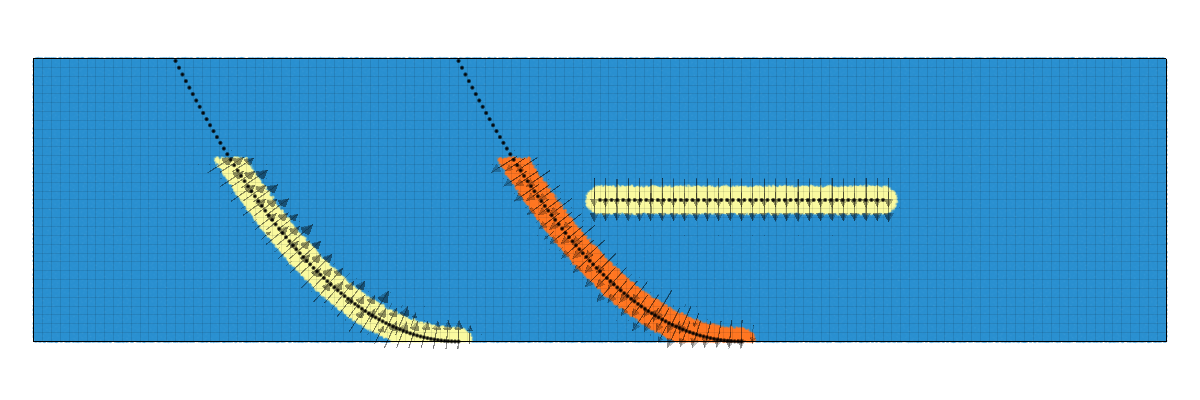

'ProxV1.png'

In [12]:
## Take a look at the locations of the materials

meshDirector = uw.mesh.MeshVariable( mesh, 2 )
projectDirector = uw.utils.MeshVariable_Projection( meshDirector, directorVector, type=1 )
projectDirector.solve()    

figMaterials = glucifer.Figure( figsize=(1200,400), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )

for f in faults:
    figMaterials.append( glucifer.objects.Points(f.swarm, colours="Black Black", pointSize=5.0, colourBar=False) )


figMaterials.append( glucifer.objects.VectorArrows(mesh, meshDirector, scaling=.1, 
                                               resolutionI=100, resolutionJ=20, opacity=0.25) )

figMaterials.append( glucifer.objects.Points(swarm, proximityVariable, 
                                             valueRange=[0.0,2.0],
                                             pointSize=5.0, colourBar=False, opacity=0.75) )
figMaterials.append( glucifer.objects.Mesh(mesh, opacity=0.1) )


figMaterials.show()
figMaterials.save_image("ProxV1.png")


### Define the viscosity function

In this case, the viscosity of material which has not reached the yield criterion is simply going to be a constant. Nevertheless, it is useful to define it here as a function and write the remaining code such that it is not changed if we introduce additional materials or a dependence on another set of equations.



In [13]:
# Interesting to test: very weak lower layer, very strong lower layer ... and something in the middle

viscosityA    = 0.01
viscosityV    = 1.0e2

friction_mu = 0.1
friction_C  = 1.0

viscosityMap     = { materialA: viscosityA,  materialV:viscosityV }

firstViscosityFn   = fn.branching.map( fn_key = materialVariable, 
                                       mapping = viscosityMap )
# Now the second viscosity (for shear)

# 2nd Viscosity is defined by delta eta (0.0 means isotropic)
viscosityA2   = 0.0  
viscosityV2   = 0.0

# Delta Visc 

viscosityTI2_fn = fn.misc.min(viscosityV*0.99999, fn.misc.max(0.0, 
                     firstViscosityFn - (friction_mu * (-edotn_SFn* viscosityV + pressureField)  + friction_C) / (fn.math.abs(edots_SFn) + 1.0e-15)))



# This one maps to my fault-proximity variable (which also picks only materialV)
viscosity2Map    = { 0: 0.0, 
                     1: viscosityTI2_fn, 
                     2: viscosityTI2_fn                   
                   }


secondViscosityFn  = fn.branching.map( fn_key = proximityVariable, 
                                       mapping = viscosity2Map )


### Deviatoric stress 

The deviatoric stress is computed from the constitutive law based on the viscosity that
results from the solution to the non-linear Stokes equation.

**Note:** the deviatoric stress is defined in terms of functions we have defined already
but the value will be meaningless if the viscosityFn is modified in any way after the 
solve is complete because evaluation is made only when the values at particular points are needed.

In [14]:

# DeviatoricStress

devStressFn = 2.0 * firstViscosityFn * strainRateFn

### Buoyancy forces

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [15]:
densityMap = { materialA: 0.0, materialV:1.0 }
densityFn = fn.branching.map( fn_key=materialVariable, mapping=densityMap )

# And the final buoyancy force function.
z_hat = ( 0.0, 100.0 )
buoyancyFn = -densityFn * z_hat

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [ ]:
stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                               pressureField  = pressureField,
                               conditions     = [velocityBCs,],
                               fn_viscosity   = firstViscosityFn, 
                              _fn_viscosity2  = secondViscosityFn,
                              _fn_director    = directorVector,                         
                               fn_bodyforce   = buoyancyFn )

solver    = uw.systems.Solver( stokesPIC )

## Initial solve (drop the non-linearity the very first solve only)
## Replace "lu" with "mumps" for parallel if you have it.

solver.set_inner_method("mumps")
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-3

# test it out

solver.solve( nonLinearIterate=True, print_stats=True )

## Surface integrals to calculate some average values

In [ ]:
surfaceArea = uw.utils.Integral(fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=topWall)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=topWall)

(area,)   = surfaceArea.evaluate()
(p0,)     = surfacePressureIntegral.evaluate() 

p0 /= area 
pressureField.data[:] -= p0 
 

In [ ]:
figVelocityPressure = glucifer.Figure( figsize=(1200,600), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )

for f in faults:
    figVelocityPressure.append( glucifer.objects.Points(f.swarm, colours="Black Black", pointSize=5.0, colourBar=False) )


figVelocityPressure.append( glucifer.objects.VectorArrows(mesh, velocityField - (2.0,0.0), scaling=.02, resolutionI=50) )
figVelocityPressure.append( glucifer.objects.Points(swarm, pointSize=5.0, fn_mask=materialVariable,
                                                    fn_colour=strainRate_2ndInvariantFn,
                                                    valueRange=[0.0,10.0],
                                                    colourBar=True, 
                                                    logScale=False,
                                                    opacity=0.5) )
# figVelocityPressure.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariantFn, logScale=True) )
figVelocityPressure.append( glucifer.objects.Mesh(mesh, opacity=0.2))
figVelocityPressure.show()

In [ ]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help

meshStrainRate  = uw.mesh.MeshVariable( mesh, 1 )
projectorStrainRate = uw.utils.MeshVariable_Projection( meshStrainRate,
                                                        strainRate_2ndInvariantFn, 
                                                        type=1 )
projectorStrainRate.solve()

figMeshStrainRate = glucifer.Figure( figsize=(1200,600), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )
figMeshStrainRate.append( glucifer.objects.Surface(mesh, meshStrainRate, 
                                                   colours="#0044BB, #777777, #FF9900",
                                                   # valueRange=[0.0,10.0] 
                                                  ))
figMeshStrainRate.show()

In [ ]:
dt = advector.get_max_dt()
advector.integrate(dt, update_owners=True)

for f in faults:
    f.advection(dt)
    
    
update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)


In [ ]:
## Evolve the mesh for a few steps

time = 0.
step = 0
nsteps = 100

# f = FloatProgress(min=0, max=10, description="Timestep")
# display(f)

exptname="Avisc1-"

while step <= nsteps:
    # Obtain V,P and remove null-space / drift in pressure
        
    solver.solve(nonLinearIterate=True)
    
#     (area,) = surfaceArea.evaluate()
#     (p0,) = surfacePressureIntegral.evaluate() 
#     pressureField.data[:] -= p0 / area
    
    dt = advector.get_max_dt()
    advector.integrate(dt, update_owners=True)
 
    for f in faults:
        f.advection(dt)


    update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
    mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)


    # Stretch mesh to match boundary conditions
    # Note that this also calls the update_particle_owners for the
    # attached swarms
                     
    with mesh.deform_mesh( remainsRegular=True ):
        mesh_vels = minXv * ( maxX - np.copy(mesh.data[:,0])) / (maxX - minX) 
        mesh.data[:,0] += mesh_vels[:]*dt

    # recalc mesh exten
    minX += minXv * dt

    pop_control.repopulate()
        
    if (step%5 ==0):   
        figVelocityPressure.save_image(exptname+str(step))
      
    if uw.rank()==0:   
          print('step = {0:6d}; time = {1:.3e};'.format(step,time))

    uw.barrier()
        
    time += dt
    step += 1